# Práctica 2 YOLOv5

La propuesta de implementación de la red de detección de imperfecciones en metales [YOLOv5 repository](https://github.com/ultralytics/yolov5) 

____________________________

Alumnas: Vicente Gilabert, Luis Rosario y Natalia Lourdes Pérez García de la Puente
Docente: José Vélez



#Instalar dependencias



In [ ]:
# clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
!git reset --hard 886f1c03d839575afecb059accf74296fad395b6

Cloning into 'yolov5'...
remote: Enumerating objects: 11301, done.
remote: Total 11301 (delta 0), reused 0 (delta 0), pack-reused 11301
Receiving objects: 100% (11301/11301), 11.20 MiB | 14.91 MiB/s, done.
Resolving deltas: 100% (7810/7810), done.
/content/yolov5
HEAD is now at 886f1c0 DDP after autoanchor reorder (#2421)


In [ ]:
# install dependencies as necessary
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch

from IPython.display import Image, clear_output  # to display images
from utils.google_utils import gdrive_download  # to download models/datasets

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

     |████████████████████████████████| 596 kB 4.0 MB/s 
Setup complete. Using torch 1.10.0+cu111 _CudaDeviceProperties(name='Tesla K80', major=3, minor=7, total_memory=11441MB, multi_processor_count=13)


# Descargar el Dataset 

Para descargar el dataset directamente de Roboflow se ha seguido [Getting Started Guide](https://blog.roboflow.ai/getting-started-with-roboflow/).

In [ ]:
#follow the link below to get your download code from from Roboflow
!pip install -q roboflow
from roboflow import Roboflow
rf = Roboflow(model_format="yolov5", notebook="roboflow-yolov5")

     |████████████████████████████████| 67 kB 2.7 MB/s 
     |████████████████████████████████| 178 kB 27.0 MB/s 
     |████████████████████████████████| 138 kB 49.7 MB/s 
     |████████████████████████████████| 1.1 MB 49.7 MB/s 
     |████████████████████████████████| 145 kB 52.4 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
upload and label your dataset, and get an API KEY here: https://app.roboflow.com/?model=yolov5&ref=roboflow-yolov5


In [ ]:
%cd /content/yolov5
#after following the link above, recieve python code with these fields filled in

from roboflow import Roboflow
rf = Roboflow(api_key="kwI9N197rEj2Mh91nRne")
project = rf.workspace("n-gd55q").project("metalv2")
dataset = project.version(1).download("yolov5")

/content/yolov5
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to metalv2-1 in yolov5pytorch:: 100%|██████████| 1810/1810 [00:01<00:00, 1117.77it/s]


In [ ]:
# this is the YAML file Roboflow wrote for us that we're loading into this notebook with our data
%cat {dataset.location}/data.yaml

names:
- inclusion
- patches
- scratches
nc: 3
train: metalv2-1/train/images
val: metalv2-1/valid/images


# Definir el modelo

Se ha considerado solo una clase: oreja y tres tipos de anchors.

In [ ]:
# define number of classes based on YAML
import yaml
with open(dataset.location + "/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [ ]:
#this is the model configuration we will use for our tutorial 
%cat /content/yolov5/models/yolov5s.yaml

# parameters
nc: 80  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, C3, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, C

In [ ]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [ ]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [ ]:
print(num_classes)

3


# Entrenar YOLOv5 


Parámetros:
- **img:** tamaño 416
- **batch:** tamaño 16
- **epochs:** 200
- **data:** path a yaml
- **cfg:** configuración del modelo
- **weights:** path
- **name:** yolo_results
- **cache:** cache images para ir más rápido

In [ ]:
# train yolov5s on custom data for 100 epochs
# time its performance
%%time
%cd /content/yolov5/
!python train.py --img 416 --batch 16 --epochs 200 --data {dataset.location}/data.yaml --cfg ./models/custom_yolov5s.yaml --weights '' --name yolov5s_results  --cache

/content/yolov5
github: ⚠️ WARNING: code is out of date by 895 commits. Use 'git pull' to update or 'git clone https://github.com/ultralytics/yolov5' to download latest.
YOLOv5 v4.0-126-g886f1c0 torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441.1875MB)

Namespace(adam=False, batch_size=16, bucket='', cache_images=True, cfg='./models/custom_yolov5s.yaml', data='/content/yolov5/metalv2-1/data.yaml', device='', entity=None, epochs=200, evolve=False, exist_ok=False, global_rank=-1, hyp='data/hyp.scratch.yaml', image_weights=False, img_size=[416, 416], linear_lr=False, local_rank=-1, log_artifacts=False, log_imgs=16, multi_scale=False, name='yolov5s_results', noautoanchor=False, nosave=False, notest=False, project='runs/train', quad=False, rect=False, resume=False, save_dir='runs/train/yolov5s_results', single_cls=False, sync_bn=False, total_batch_size=16, weights='', workers=8, world_size=1)
wandb: Install Weights & Biases for YOLOv5 logging with 'pip install wandb' (recommended)
Start Tensorboa

# Evaluar YOLOv5 Performance

In [ ]:
# Start tensorboard
# Launch after you have started training
# logs save in the folder "runs"
%load_ext tensorboard
%tensorboard --logdir runs

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


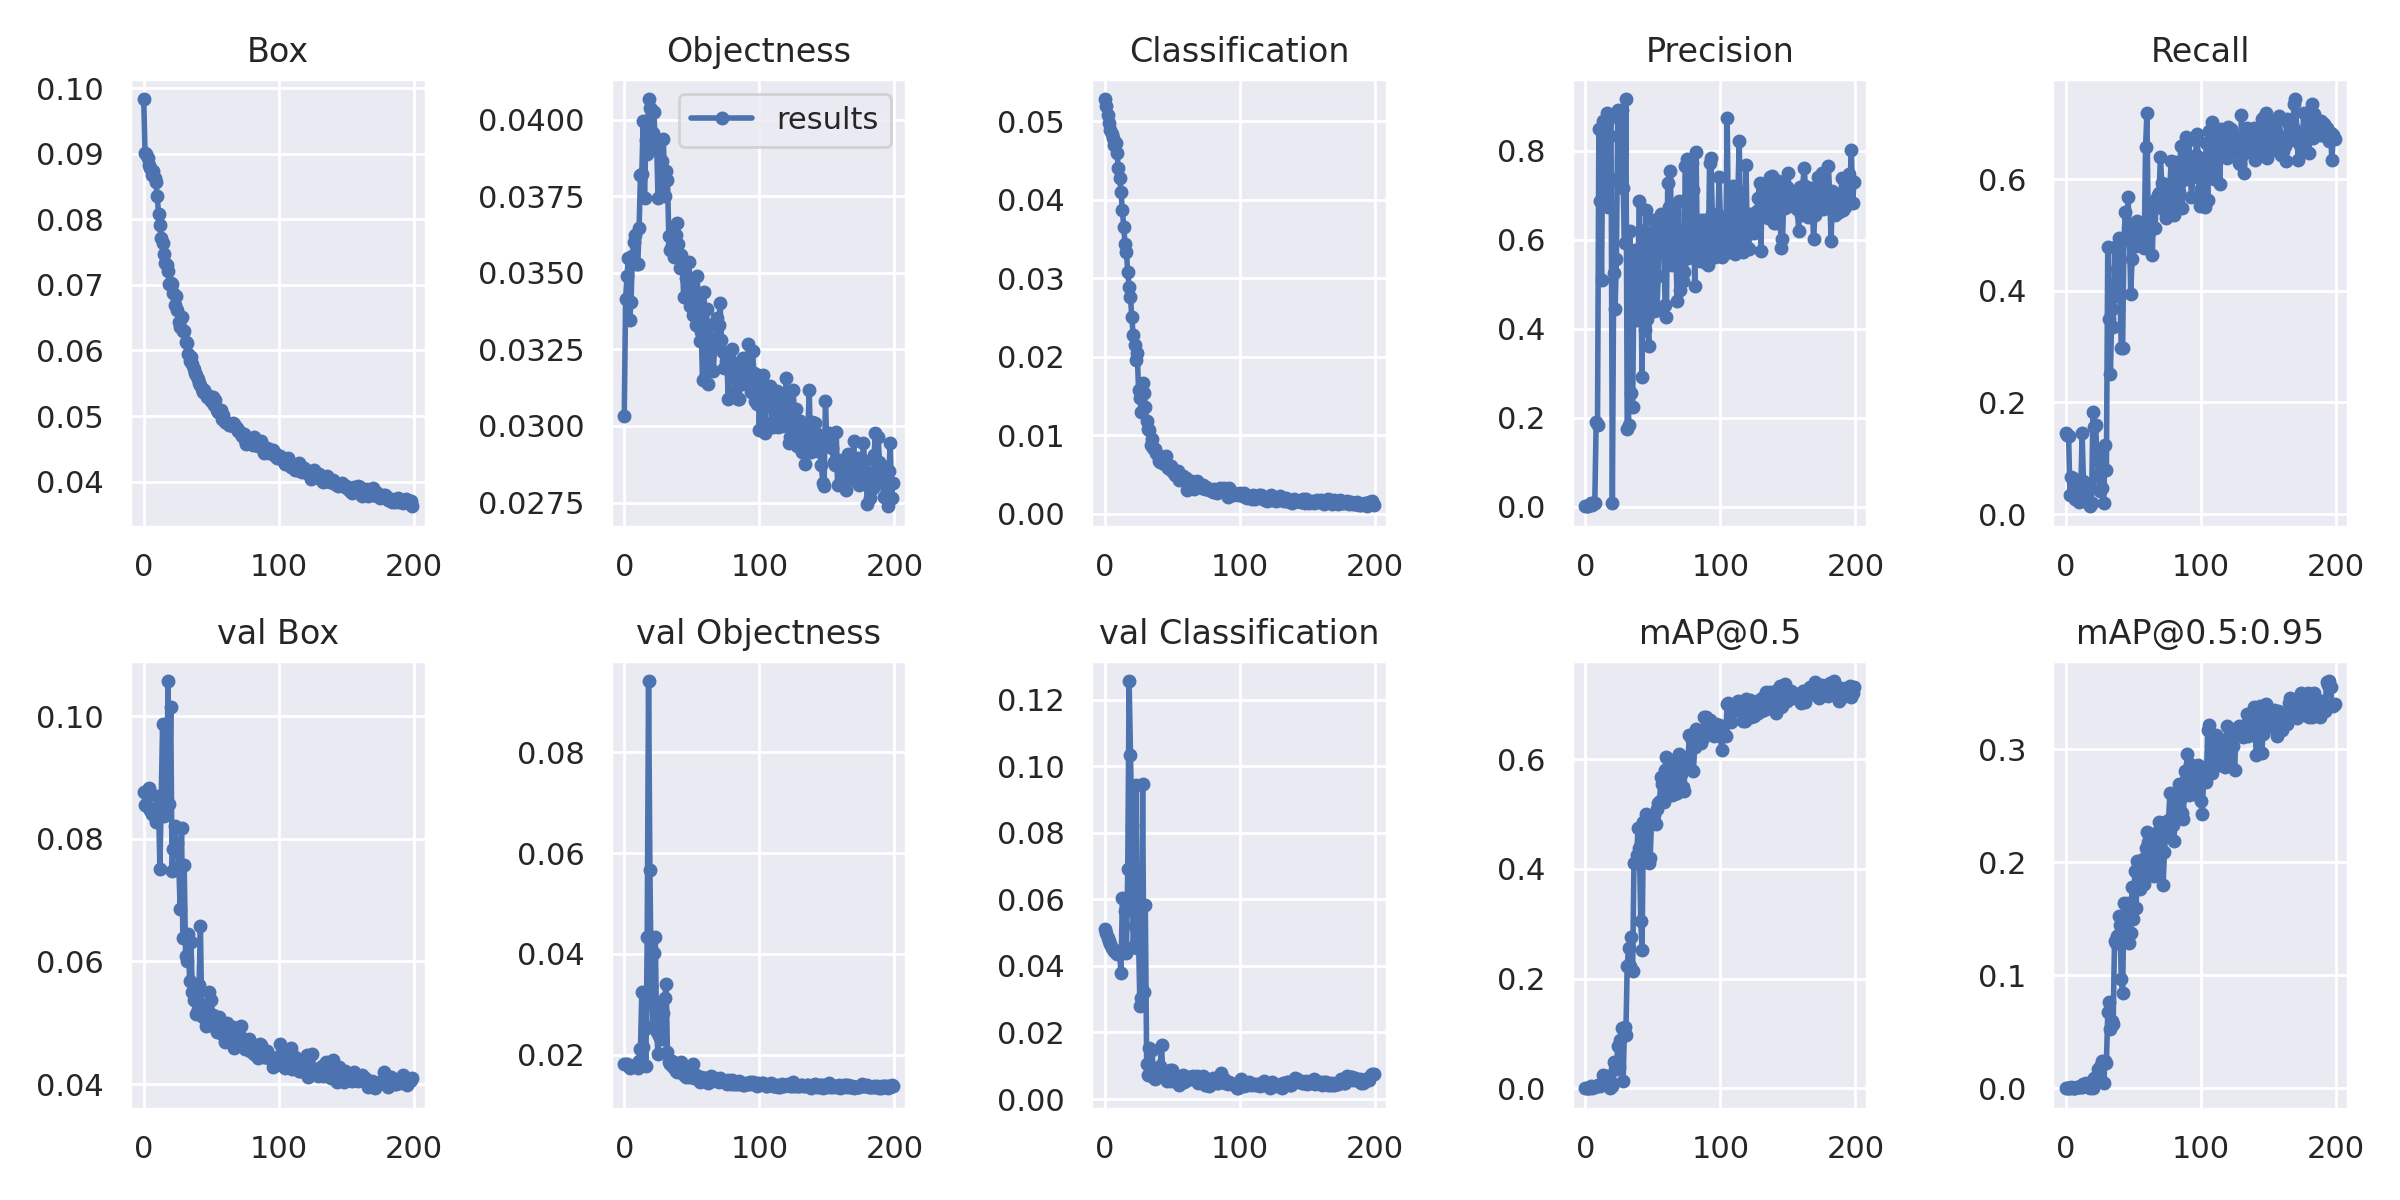

In [ ]:
# we can also output some older school graphs if the tensor board isn't working for whatever reason... 
from utils.plots import plot_results  # plot results.txt as results.png
Image(filename='/content/yolov5/runs/train/yolov5s_results2/results.png', width=1000)  # view results.png

### Visualizar Datos de Train

GROUND TRUTH TRAINING DATA:


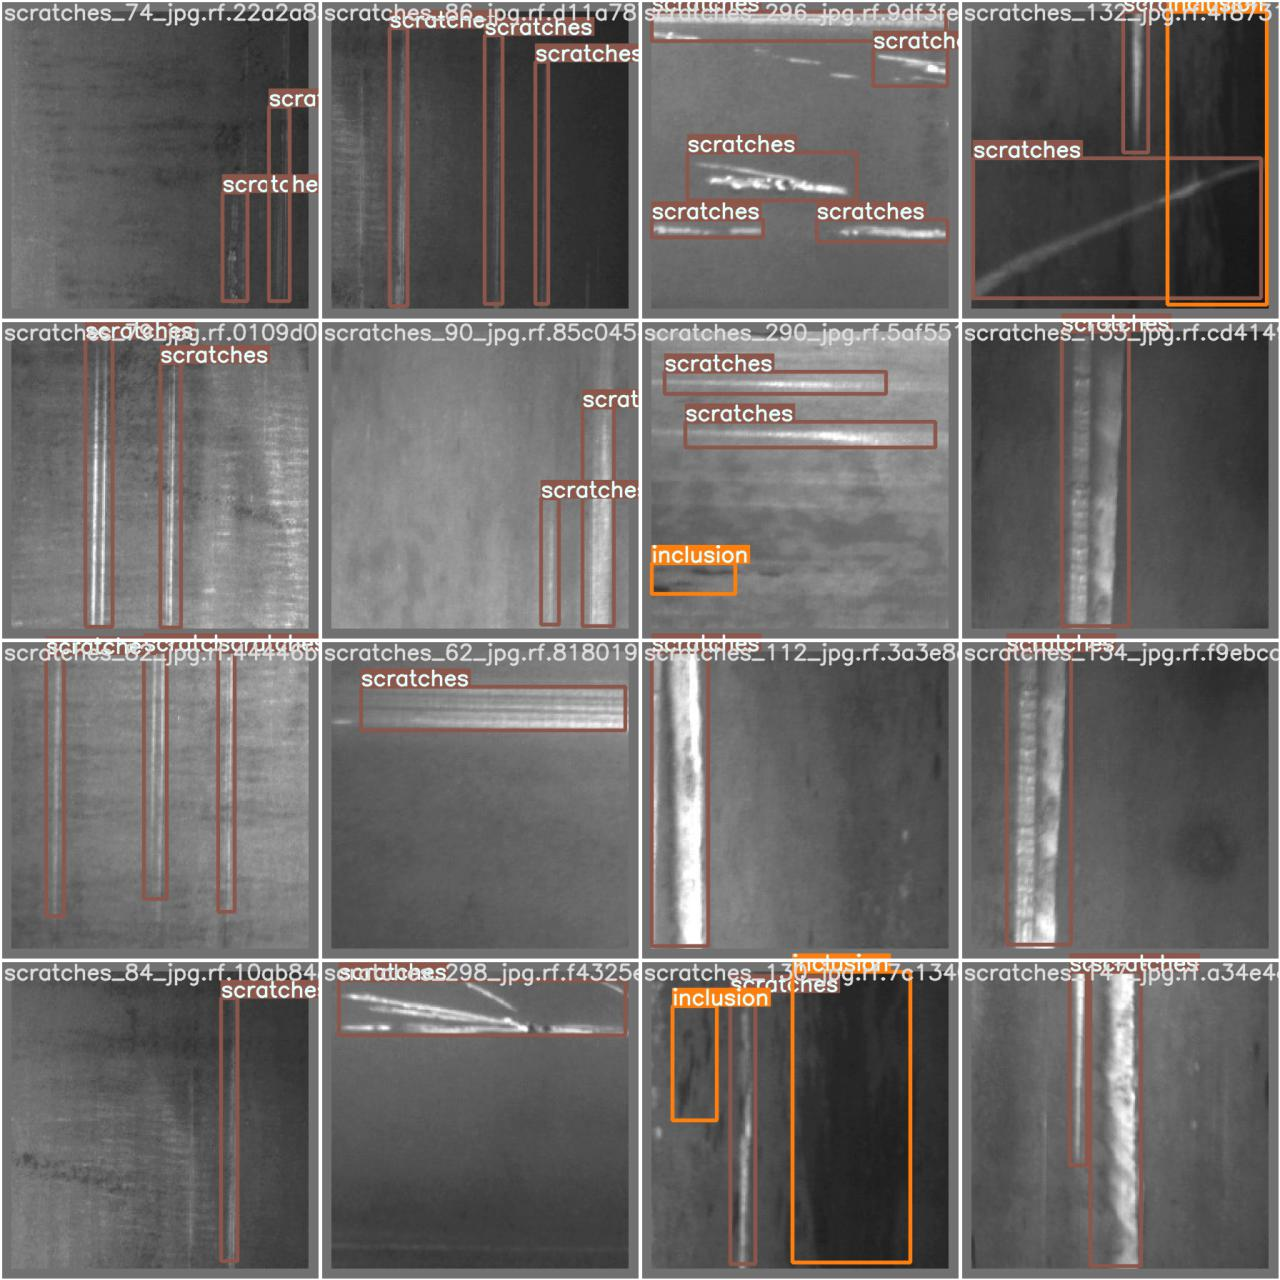

In [ ]:
# first, display our ground truth data
print("GROUND TRUTH TRAINING DATA:")
Image(filename='/content/yolov5/runs/train/yolov5s_results2/test_batch2_labels.jpg', width=900)